In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%autosave 0
from fastai.column_data import *
import seaborn as sns
warnings.filterwarnings('ignore')

Autosave disabled


### Generate Data

Create input features - x1, x2, and x3 - and their effect on the reponse variable through the `scale` object. We'll later pass `scale` to numpy's `random.gamma()` method to generate a gamma-distributed response variable.

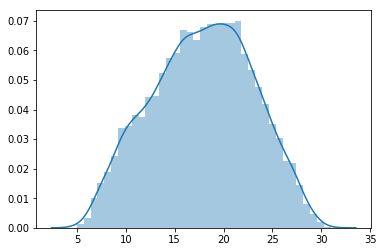

In [2]:
n = 10000
np.random.seed(90210)
x1 = np.random.uniform(0, 5, n)
x2 = np.random.normal(100, 20, n)
x3 = np.random.choice((1,2,3,4,5), n, p = (0.35, 0.2, 0.05, 0.25, 0.15))
scale = np.clip(3.2 * x1 + 0.05 * x2 + 2.15 * x3 - 0.12*x1*x3, a_min = 5, a_max = 1e15)
sns.distplot(scale)

Observation weights, `w`, will also be randomly generated. Each record in the dataset will be observed between 0.5 and 1.5 time units. This type of data often appears in modeling problems where observation periods vary between records in the dataset or when new records are created when something about the observational unit changes throughout the observation period. It is very common in insurance modeling, for instance.

In [3]:
w = np.random.uniform(0.5, 1.5, n)

Standardize the numerical features for the neural network. We'll assume that `x3` is categorical and so this only needs to be done for `x1` and `x2`. Note tha we standardize with the weighted mean and weighted standard deviation. It woud likely be fine to not standardize with weights.

In [4]:
def standardize(x, w):
    wgtd_avg = np.average(x, weights = w)
    wgtd_avg_2 = np.average(x**2, weights = w)
    return (x - wgtd_avg) / np.sqrt(wgtd_avg_2 - wgtd_avg**2)

In [5]:
x1 = standardize(x1, w)
x2 = standardize(x2, w)

Bundle the input features into both a numpy array and then a pandas dataframe. For our model, we'll need to select an embedding size for feature `x3`. We'll use the formula: \begin{equation*} embeddings = floor(\frac{cardinality\ of\ feature + 1}{2}) \end{equation*}

In [6]:
x = np.stack((x1, x2, x3), axis = 1)
df = pd.DataFrame(x, columns = ['x1', 'x2', 'x3'])
df['x3'] = df.x3.astype('category').cat.codes
x3_uniques = df.x3.nunique()
emb_sz = [(x3_uniques, (x3_uniques + 1)//2)]

Finally, create a gamma-distributed response variable, `y`, which is assumed to have a scale parameter defined by the linear combination of the input features encoded into `scale` with a constant shape parameter of `1.2`.

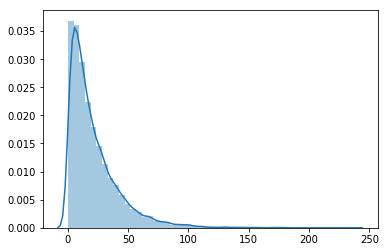

In [7]:
y = np.random.gamma(shape = 1.2, scale = scale, size = n)
y_range = [0., y.max()]
sns.distplot(y)

### Model Data Object

We'll make model data object from the pandas dataframe, `x` that we created above. Notice the new method `from_data_frame_wgts` and the argument `w` for observation weights. Every method that has been updated to account for observation weights will have a `_wgts` suffix and will take a `w` argument

In [8]:
val_idxs = np.random.permutation(len(y))[:3000]

In [9]:
md_frame = ColumnarModelData.from_data_frame_wgts(path = '.', val_idxs = val_idxs, df = df, y = y, w = w, cat_flds = ['x3'], bs = 64)

Let's make sure that we can find the observation weights in the training dataset

In [10]:
md_frame.trn_w.shape, md_frame.trn_w[0:10]

((7000, 1), array([[1.27281],
        [0.60026],
        [1.17155],
        [0.8497 ],
        [0.52879],
        [0.50638],
        [1.25269],
        [1.40499],
        [0.96872],
        [1.38995]]))

### Custom Loss and Evaluation Metric

Now that we have observational weights in our datasets and data loaders, we need to make sure our model's loss function and our evaluation metric that we'll be using to monitor learning can accept observational weights. Not doing so will cause an error. PyTorch doesn't not supply weighted loss functions, so we'll need to create our own. Deviance, which is a general distance measure between prediction and response that accounts for non-nomal response distributions, is a good choice for our loss function. It is proportional to negative loglikelihood. See https://en.wikipedia.org/wiki/Deviance_(statistics). To monitor training we'll use weighted Mean Absolute Error.

In [11]:
def wgtd_dev(prds, resp, wgts):
    prds.data.clamp_(min = 1e-5) # predictions must be positive
    dev = -2.0 * wgts * (torch.log(resp/prds) - (resp - prds) / prds)
    return dev.sum() / wgts.sum()

def wgtd_mae(prds, resp, wgts):
    ae = torch.abs(prds - resp)
    return ae.sum() / wgts.sum()

### Train model

On the first pass, we'll not use a fastai `learner`. Instead, we'll pass the model data and model itself to the `fit` function.

In [12]:
m = MixedInputModel(emb_szs = emb_sz, n_cont = len(df.columns)-1, emb_drop = 0., out_sz = 1, szs = [10],
                    drops = [0.1], y_range = y_range, use_bn = True)
opt = optim.Adam(m.parameters(), 1e-3)
fit(model = m, data = md_frame, n_epochs = 3, opt = opt, crit = wgtd_dev, metrics = [wgtd_mae])

epoch      trn_loss   val_loss   wgtd_mae                                                                              
    0      2.551857   2.260304   62.414538 
    1      1.4651     1.075139   18.005387                                                                             
    2      1.083785   0.984699   15.648591                                                                             



[array([0.9847]), 15.64859113387261]

Now we'll use a `learner` object so that we can find a good learning rate. Notice that we need to pass our user-defined loss function to `crit=`.

In [13]:
learner = md_frame.get_learner(emb_szs = emb_sz, n_cont = len(df.columns)-1, emb_drop = 0., out_sz = 1,
                               szs = [10], drops = [0.1], y_range = y_range, use_bn = True, 
                               crit = wgtd_dev, metrics = [wgtd_mae])

In [14]:
learner.lr_find()

 44%|██████████████████████████████                                       | 48/110 [00:00<00:00, 479.98it/s, loss=2.64]


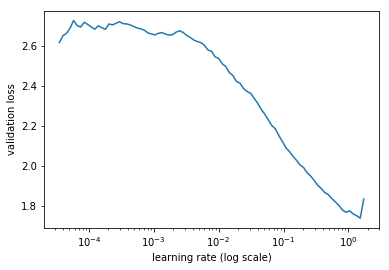

In [15]:
learner.sched.plot(n_skip_end = 0)

Looks like we can select a large learning rate. Let's select `0.2`

In [16]:
learner.fit(lrs = 0.2, n_cycle = 3)

epoch      trn_loss   val_loss   wgtd_mae                                                                              
    0      1.060752   0.948967   14.140661 
    1      1.001423   1.033588   13.873948                                                                             
    2      0.980037   0.986358   15.62873                                                                              



[array([0.98636]), 15.6287303577572]